In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
import seaborn as sns; sns.set_context('notebook')
import warnings
warnings.simplefilter("ignore")
az.style.use('arviz-darkgrid')
np.random.seed(44)


In [2]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    "figure.figsize": [8, 4],
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Hierarchical linear regression


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on..

*  Chris Fonnesbeck, <a href="https://github.com/fonnesbeck/bayes_course_july2020">Bayesian Computing Course</a>
*  O. Martin, *Bayesian analysis with Python*, Ch. 3

# Hierarchical regression

* Hierarchical  regression is  a generalization of linear regression, which allows the  parameters to **vary by group**.


* This allows modelling observations which are  *grouped*  (or *clustered*). 

# Hierarchical (or multilevel) modeling

A *hierarchical model* provides a compromise between:

* the *pooled model*, which fits a single regression by merging all observations; this is  excessively constrained; 


* the *unpooled model*, which fits an independent regression for each cluster.  This is unreliable on cluster containing few observations and there is no generalization to unobserved groups.

# The radon data set (Gelman et al., 2007)

<img src='img/how_radon_enters.jpg' width=400 align="center" >

# The radon data set (Gelman et al., 2007)



* Radon gas is a radioactive gas; it is  the highest cause of lung cancer in non-smokers.



* Its level is  generally higher in the basement; moreover, its presence depends on the  type of soil.

# Radon contamination in Minnesota

* We will model radon levels in Minnesota. The state is divided in 85 different *counties*.


* For each measure we know:
    * the county in which the measure is taken
    * the floor (basement or  first floor) 

### Data organization

In [22]:
# Import radon data, 919 rows
radon_data = pd.read_csv('data/radon.csv', index_col=0)


#The processing below generates standardized X and Y ( floor_std ,  log_radon_std) and the 
#index of the county for each measure. There is a different number of measures for each county.

#list of  counties in Minnesota (85 different counties)
counties      = radon_data.county.unique()
n_counties = counties.shape[0] 

#numerical id of the county of each measure (919 rows)
county               = radon_data.county_code.values
#code and name of each county
county_lookup = dict(zip(counties, np.arange(n_counties)))

#explanatory variable: the floor: 0 (ground level) or 1 (first floor).
#we standardize x to avoid correlation in the posterior.
floor           = radon_data.floor.values
floor_std   = (floor - floor.mean()) / floor.std()

#y 
log_radon         = radon_data.log_radon.values
#standardization of y is useful to set the prior without worrying about the scale of the data.
log_radon_std = (log_radon - log_radon.mean()) / log_radon.std()

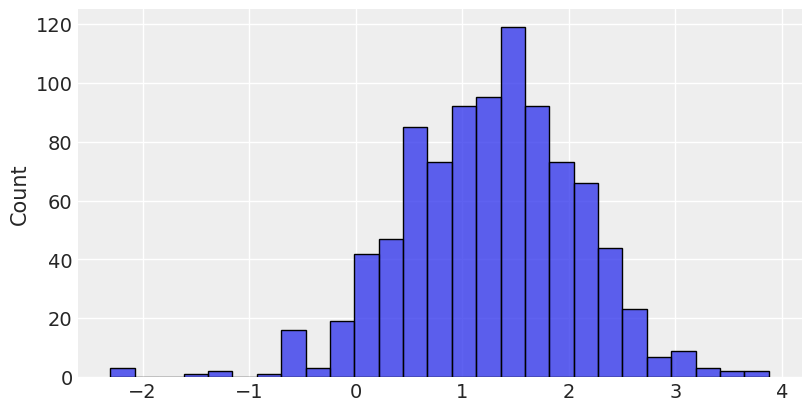

In [23]:
#Distribution of radon levels in MN (log scale):

sns.histplot(log_radon);

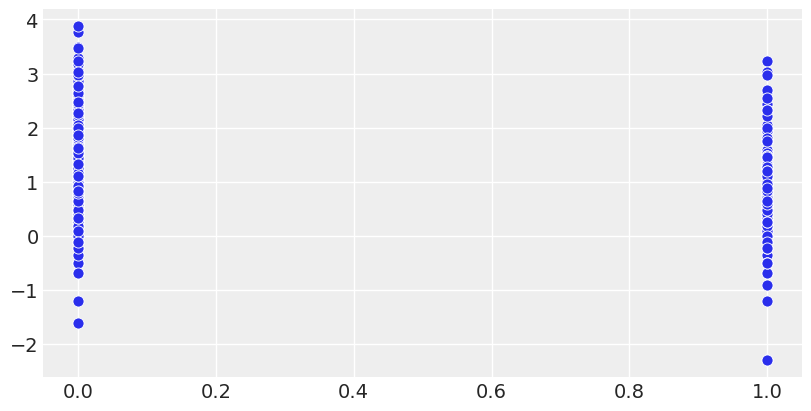

In [25]:
#as floor takes only 0 and 1 as values, we have data organized into two columns 
#here we are plotting the original  floor value (non standardized).
#The radon level is higher in the basement (floor = 0) than in the first floor (floor = 1).
sns.scatterplot(floor, log_radon);

# Pooled regression

A regression model which ignores the county:

$$y_i \sim N( \alpha + \beta x_i, \sigma)$$


* $y_i$: log-radon measured in the $i$-th household ($i$=1,2,...919)

* $x_i$: floor of the measurement in the $i$-th household (1 or 0); we will work with the standardized variable `floor_std`

* $\alpha$ : intercept.  (on  centered data, it represents the mean log-radon in Minnesota). 


# Pooled regression 

* We have no prior knowledge; we thus use  standard priors assuming the data to be centered and standardized:

\begin{align}
y_i  &\sim N( \alpha + \beta x_i,  \sigma) && \text{likelihood}\\
\alpha &\sim N(0,1) && \text{prior on the intercept} \\
\beta  & \sim N (0,1)  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1) && \text{prior on the dev std } \\
\end{align}

# Unpooled regression 


$$y_i \sim N( \alpha_{j[i]} + \beta x_i, \sigma) $$

* $\alpha_{j[i]}$ : the intercept for the county where household $i$ is located (think of  $j$ as an array containing the county code for each measure)


* For each county we have a different and independent  intercept.


# Unpooled regression


$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

* The slope $\beta$ is equal for all counties; we assume that the difference between floor and basement does not depend on the county.



# Unpooled model

\begin{align}
y_i  &\sim N( \alpha_{j[i]} + \beta x_i,  \sigma) && \text{likelihood}\\
\alpha_j &\sim N(0,1) \,\, j=1,2..., 85&& \text{prior on the intercept} \\
\beta & \sim N (0,1)  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1) && \text{prior on the dev std} \\
\end{align}

# Discussion

* The pooled model assumes  all observations to be samples from the same process,  ignoring the effect of the county.


* The unpooled model learns from scratch the intercept (baseline level) of every county, without transferring any information between intercepts of the different counties.

# Implementation

In [6]:
#pooled model

with pm.Model() as pooled_model:

    alpha = pm.Normal('alpha', mu=0,  sigma=1)
    beta   = pm.Normal('beta', mu=0,  sigma=1)
    sigma = pm.HalfNormal('sigma', 1)
    
    #we use floor_std as x to avoid an effective sampling
    y = pm.Normal('y', alpha + beta * floor_std, sigma, observed=log_radon_std)
    

In [7]:
with pooled_model:
    pooled_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


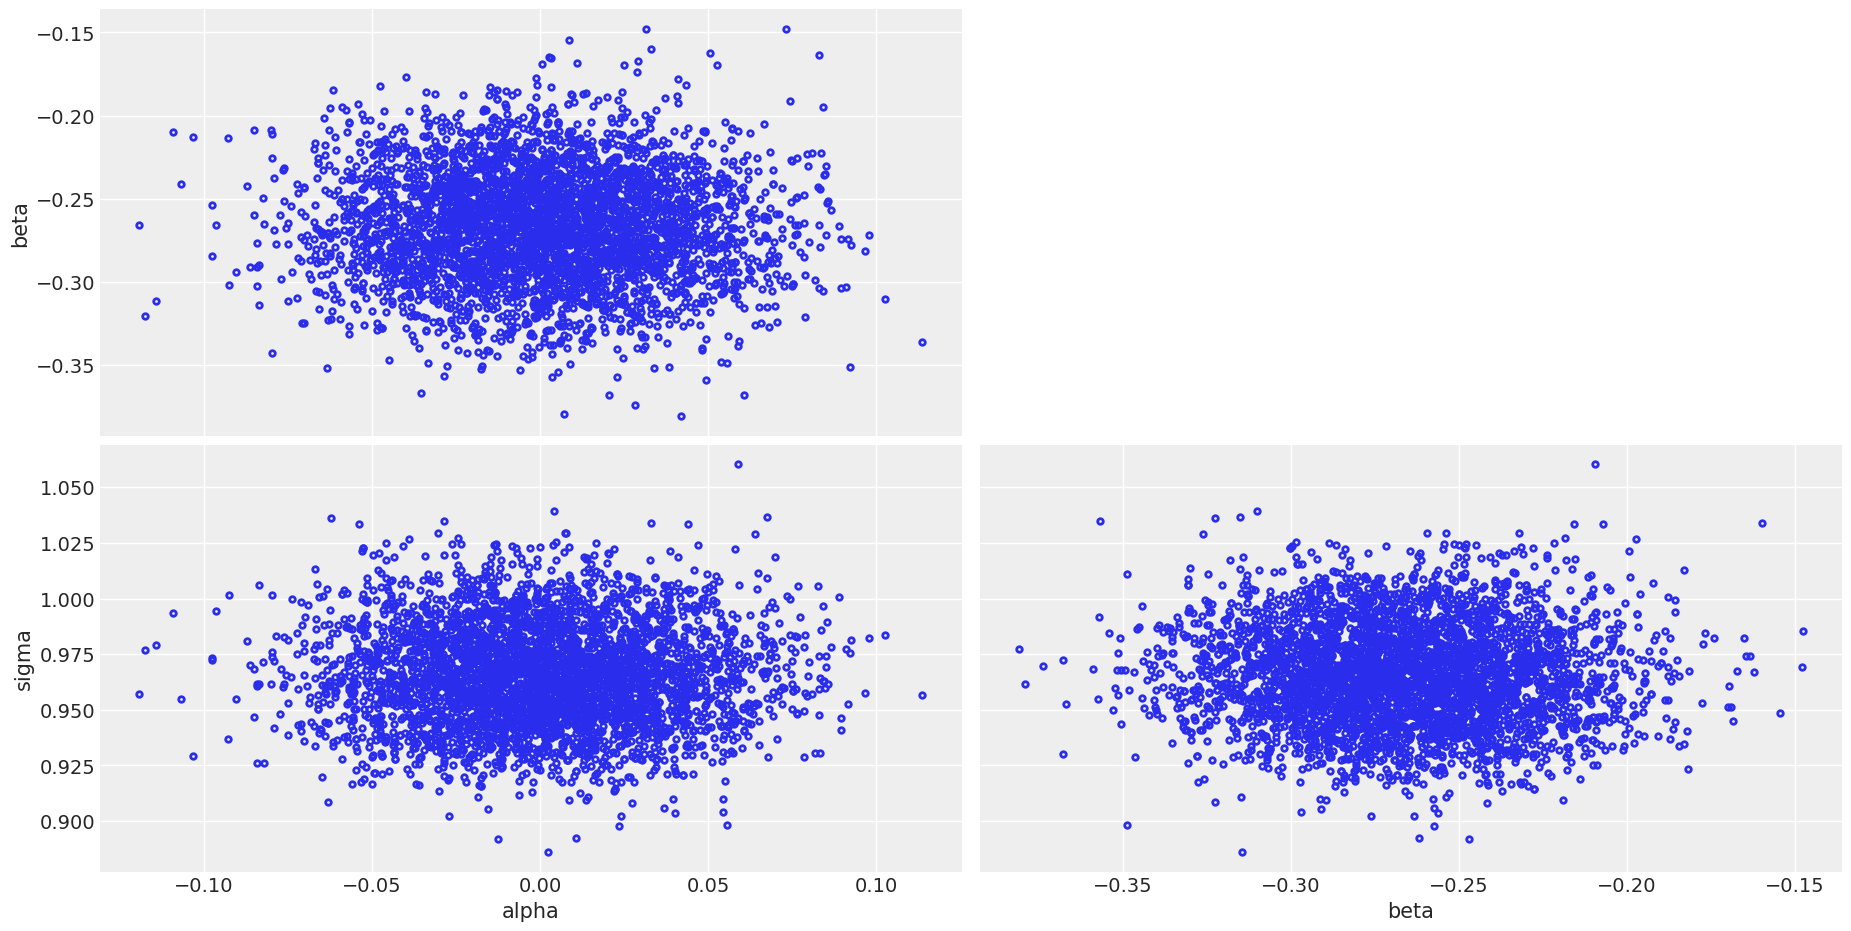

In [8]:
    #standardization of x removes correlation in the posterior.
with pooled_model:
        az.plot_pair(pooled_trace);

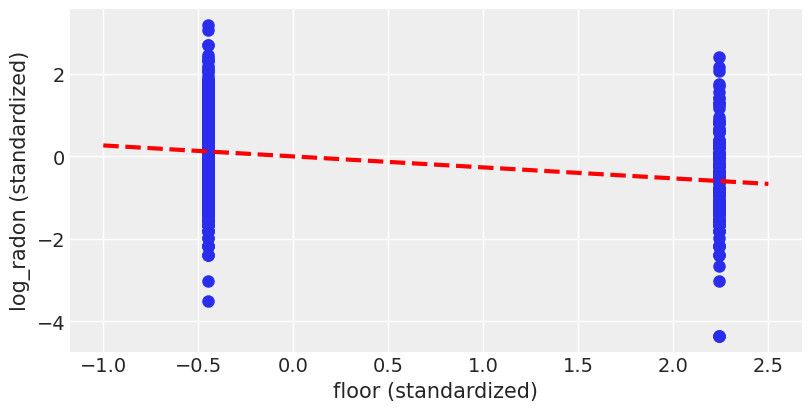

In [9]:
# posterior mean of the parameters
post_pooled = az.extract_dataset(pooled_trace)
a_pooled      =  post_pooled.alpha.values.mean()
b_pooled      = post_pooled.beta.values.mean()

plt.scatter(floor_std, log_radon_std)
xvals = np.linspace(-1, 2.5)
plt.plot(xvals, b_pooled * xvals + a_pooled, 'r--')
plt.xlabel('floor (standardized)')
plt.ylabel('log_radon (standardized)');

# Implementing  the unpooled model

In [10]:
with pm.Model() as unpooled_model:
    # a different intercept for each county
    alpha = pm.Normal('alpha', mu=0, sigma=1, shape=n_counties)

    # the slope is the same for all counties
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma   = pm.HalfNormal('sigma', 1)
    
    #county is a vector containing the county index  for each measure.
    mu = alpha[county] + beta *floor_std
    
    y = pm.Normal('y', mu, sigma=sigma, observed=log_radon_std)
    

In [11]:
with unpooled_model:
    unpooled_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


## Comparing the pooled and unpooled model

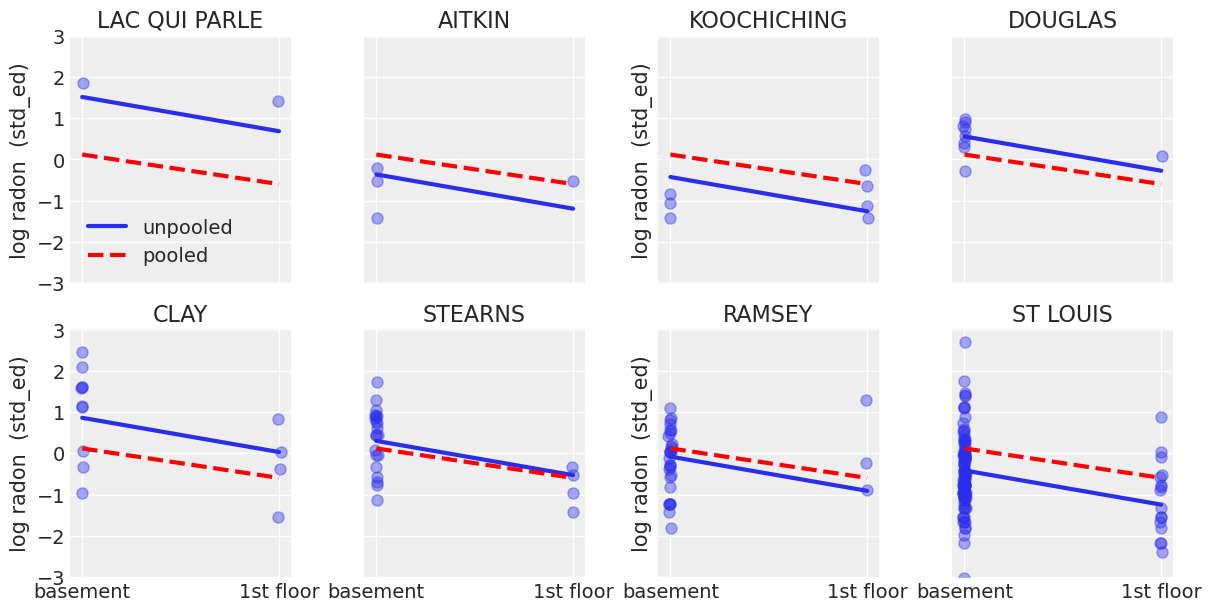

In [12]:
#The code below shows the pooled and unpooled model for some sample counties.
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

#slope of the unpooled model (posterior mean)
unpooled_post = az.extract_dataset(unpooled_trace)
beta_unpooled = unpooled_post.beta.values.mean()

# intercept of the unpooled model (posterior mean): an array, one element for each county.
#alpha_unpooled = pd.Series(unpooled_trace['alpha'].mean(axis=0), index=counties)
alpha_unpooled = pd.Series(unpooled_post.alpha.values.mean(axis=1), index=counties)

for i,c in enumerate(sample_counties):
    #select the subset of observation referring to the specific county
    y = log_radon_std[radon_data.county==c]
    x = floor_std[radon_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    

    # Plot both models and data
    xvals = np.linspace(floor_std.min(), floor_std.max() )
    # Unpooled model
    axes[i].plot(xvals,  alpha_unpooled[c] + beta_unpooled * xvals,  label="unpooled" )
    axes[i].plot(xvals,  a_pooled + b_pooled * xvals, 'r--', label="pooled")
    axes[i].set_xticks([floor_std.min(), floor_std.max()])
    axes[i].set_xticklabels(['basement', '1st floor'])
    axes[i].set_ylim(-3 ,3)
    axes[i].set_title(c)
    if not i%2: axes[i].set_ylabel('log radon  (std_ed)')
    axes[0].legend()

plt.savefig('img/pooled_unpooled.png')

<img src='img/pooled_unpooled.png' width=1000 align="center" >

* The pooled model (red) does not identify high-radon counties

* The high estimate of the unpooled models (blue)  for LAC QUI PARLE is suspect, as it is based on few  observations.

# Hierarchical regression


* A different intercept for each county.


*  It models  the population of  intercepts.


* This is referred to as a  *varying intercept* model.


* Its estimates are a compromise between the unpooled and the pooled model.

# Hierarchical varying-intercept model

\begin{align}
y_i  &\sim N( \alpha_{j[i]} + \beta x_i,  \sigma) && \text{likelihood} \\
\beta & \sim N (0,1)  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1) && \text{prior on the dev std} \\
\alpha_j &\sim N(\mu_{\alpha}, \sigma_{\alpha}) \,\, j=1,2..., 85&& \text{population of intercepts} \\
\mu_{\alpha} &\sim N(0,10)  && \text{prior on the mean intercept} \\
\sigma_{\alpha} &\sim \text{half-normal}(5) && \text{prior on the std of intercepts}\\
\end{align}

In [26]:
with pm.Model() as hier_model:
    
    # Population of intercepts
    mu_a     = pm.Normal('mu_a', mu=0., sigma=10)
    sigma_a = pm.HalfNormal('sigma_a', 5)
    
    # Each intercept is drawn from the population of intercepts
    alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=n_counties)
    
    # Common slope
    beta = pm.Normal('beta', mu=0, sigma=1)

    # Expected value
    y_hat = alpha[county] + beta * floor_std
    
    # Std dev control how much the observation deviated from the expected regression line
    sigma_y = pm.HalfCauchy('sigma_y',1)
    
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon_std)    

In [14]:
with hier_model:
    hier_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, beta, alpha, sigma_a, mu_a]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
The number of effective samples is smaller than 25% for some parameters.


## Partial pooling 

* The estimate of the hierarchical model is a compromise, based on sample size, between the pooled and unpooled model  (*partial pooling*):


$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

* Estimates for counties with smaller sample sizes will shrink towards the state-wide average.

* Estimates for counties with larger sample sizes will be closer to the unpooled county estimates.

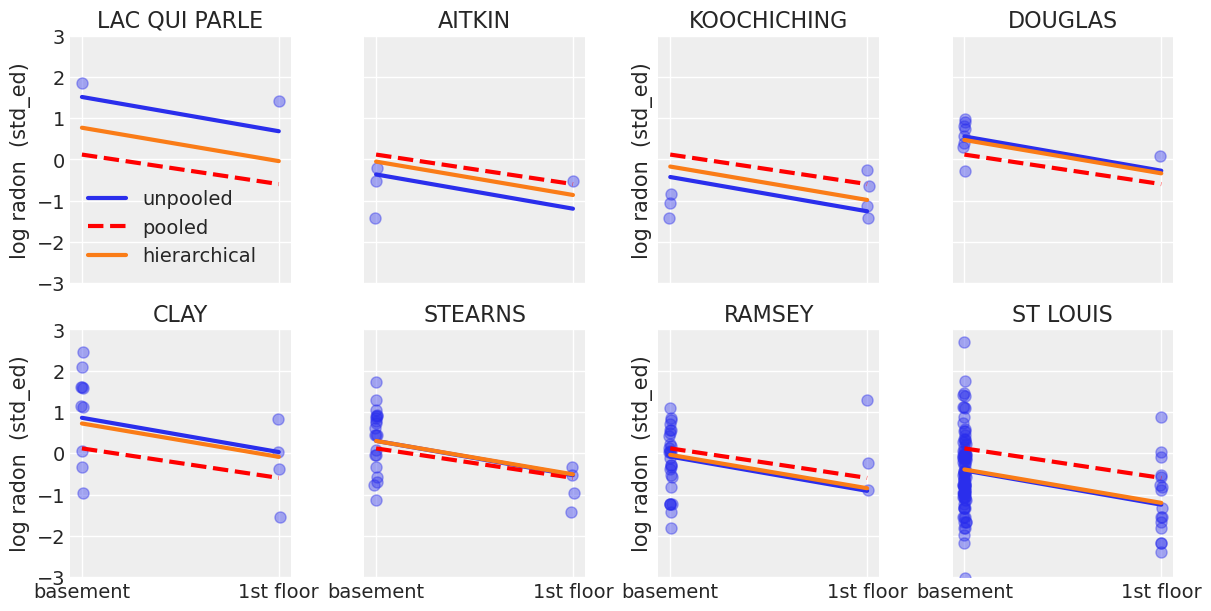

In [15]:
#the code below compare the estimates provided by the pooled, unpooled and hierarchical model
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

post_hier   = az.extract_dataset(hier_trace.posterior)

#slope of the hier model (posterior mean)
beta_hier = post_hier.beta.values.mean()

# intercept of the hier model: an array, one element for each county (samples of each county are averaged)
alpha_hier = pd.Series(post_hier.alpha.values.mean(axis=1), index=counties)


for i,c in enumerate(sample_counties):
    
    # Plot county data
    y = log_radon_std[radon_data.county==c]
    x = floor_std[radon_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    
    xvals = np.linspace(floor_std.min(), floor_std.max() )
    # Unpooled model
    axes[i].plot(xvals,  alpha_unpooled[county_lookup[c]] + beta_unpooled * xvals,  label="unpooled" )
    # Pooled model
    axes[i].plot(xvals,  a_pooled + b_pooled * xvals, 'r--', label="pooled")
    # Hierarchical model
    axes[i].plot(xvals,  alpha_hier[county_lookup[c]] + beta_hier * xvals,  label="hierarchical" )
    #axes[i].plot(xvals, mp*xvals+ beta_hier[county_lookup[c]], 'k:')
    
    axes[i].set_xticks([floor_std.min(), floor_std.max()])
    axes[i].set_xticklabels(['basement', '1st floor'])
    axes[i].set_ylim(-3 ,3)
    axes[i].set_title(c)
    if not i%2: axes[i].set_ylabel('log radon  (std_ed)')
    axes[0].legend()

plt.savefig('img/pooled_unpooled_hier.png') 

#  The hierarchical model is a sensible compromise 

<img src='img/pooled_unpooled_hier.png' width=900 align="center" >

* Close to the unpooled model on data-rich counties.

* Close to the pooled model on data-poor counties.

# Ranking models according to WAIC

* WAIC is a model selection criterion for Bayesian models.



In [16]:
# the hierarchical model is ranked first
az.waic (pooled_trace)
az.compare({'pooled':pooled_trace, 'unpooled': unpooled_trace,  'hierarchical':hier_trace}, ic='waic')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
hierarchical,0,-1219.886178,49.017738,0.000000,0.910780,27.999936,0.000000,True,log
unpooled,1,-1231.849929,73.554106,11.963750,0.013741,28.361490,4.491167,True,log
pooled,2,-1273.519172,3.776212,53.632994,0.075478,25.034500,10.750339,False,log


# Prediction

Gelman (2006) used cross-validation tests to check the prediction error of the unpooled, pooled, and partially-pooled models

**root mean squared cross-validation prediction errors**:

* unpooled = 0.86
* pooled = 0.84
* multilevel = 0.79

There are two types of prediction that can be made in a multilevel model:

1. a new individual within an existing group
2. a new individual within a new group



# Your turn: compute predictive distributions

* Using the unpooled and the hierarchical model:

    *  the predictive distribution  for a measurement taken in the basement (floor = 0, floor_std = -0.446) in   'LAC QUI PARLE' county,   


* Using hierarchical model:
    * predictive distribution for a measurement taken in the basement for a new county.

# Solutions

In [29]:
#predictive distribution for a new measure in LAC QUI PARLE, according to the hierarchical and the unpooled model
# Part 1

#np.unique(floor_std)
#array([-0.44692159,  2.23752898])
floor_0 = -0.44692159

#get the trace samples
post_hier    = az.extract_dataset(hier_trace.posterior)
post_unp    = az.extract_dataset(unpooled_trace.posterior)

#samples of the slope
beta_hier =  post_hier.beta.values
beta_unp =  post_unp.beta.values

#samples of the intercept for LAC 
alpha_lac_hier = post_hier.alpha.values[county_lookup['LAC QUI PARLE']] 
alpha_lac_unp = post_unp.alpha.values[county_lookup['LAC QUI PARLE']] 

#samples of sd
sigma_y =  post_hier.sigma_y.values

In [42]:
#Part 2 - Conclusion
y_new_hier = np.zeros(len(beta_hier))
y_new_unp = np.zeros(len(beta_unp))

for i, current_mu in enumerate(beta_hier):
        #to have a more precise quantification, we could generate more than one values   with the i-th sample of parameters.
        # that is how pymc3 implements the predictive checks.
        y_new_hier[i] = np.random.normal (loc = alpha_lac_hier[i] + beta_hier[i] *  floor_0 , scale = sigma_y[i])
        y_new_unp[i] = np.random.normal (loc = alpha_lac_unp[i] + beta_unp[i] *  floor_0 , scale = sigma_y[i])

#the predictive distribution of the unpooled is much larger median and more uncertaint (larger std)        
a=  pd.DataFrame(y_new_hier).describe()
b = pd.DataFrame(y_new_unp).describe()
c =  pd.concat ([a,b], axis=1)
c.columns = ['hier', 'unpooled']
c

,hier,unpooled
count,4000.000000,4000.000000
mean,0.751261,1.504414
std,0.949563,1.030655
min,-2.526125,-2.060104
25%,0.110723,0.791409
50%,0.729371,1.508039
75%,1.392261,2.215763
max,3.810411,5.158374


In [43]:
# predictive distribution for a measure taken in a new county.
# First, we create plausible value of intercepts by sampling from the population of intercepts 

#get the trace samples for beta and sigma_y as in the above cell
post_hier    = az.extract_dataset(hier_trace.posterior)
beta_hier =  post_hier.beta.values
sigma_y =  post_hier.sigma_y.values

#sample intercepts from the population of intercepts and store the sampled values in alpha_new
mu_a = post_hier.mu_a.values
sigma_a = post_hier.sigma_a.values

alpha_new = np.zeros(len(mu_a))
for i, current_mu in enumerate(mu_a):
    alpha_new[i] = np.random.normal (loc = mu_a[i], scale = sigma_a[i])
    
    
    
#predictive distribution for a new measure in the new county
y_new = np.zeros(len(alpha_new))


for i, current_mu in enumerate(alpha_new):
        y_new[i] = np.random.normal (loc = alpha_new[i] + beta_hier[i] *  floor_0 , scale = sigma_y[i])

 
# the predictive distribution of the hierarchical has median 0.72
print("predictive for a new measure taken in a new county:")
print(pd.DataFrame(y_new).describe())
print("\n")

predictive for a new measure taken in a new county:
                 0
count  4000.000000
mean      0.275863
std       0.976357
min      -2.916270
25%      -0.385052
50%       0.266425
75%       0.935021
max       3.796938


